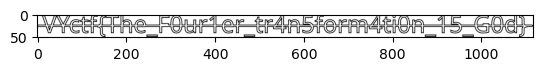

In [4]:
from PIL import Image
import requests
from io import BytesIO
import pylab
img = Image.open("./flag.png")
pylab.imshow(img)
pylab.show()

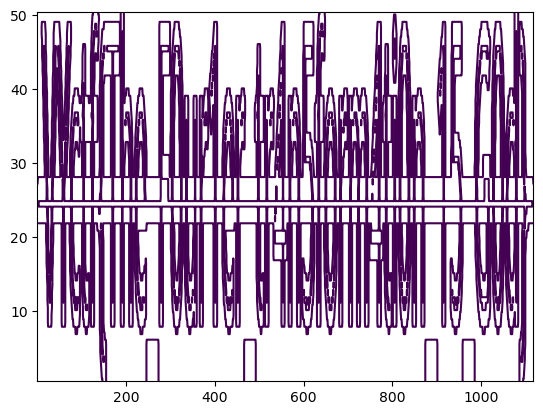

In [17]:
img = img.convert('L')
fig, ax = pylab.subplots()
contours = ax.contour(img, origin='image', levels=[50])
pylab.show()

In [19]:
import numpy as np
raw_data = []
print(contours.allsegs)
segs = np.array(contours.allsegs) / max(img.width, img.height)
reverse_idx = {}
for seg in segs:
    for poly in seg:
        # down sample 1: make points more discrete
        poly = (np.array(poly) * 1000).astype(int) / 1000
        poly = [tuple(p) for p in poly]

        # index points and deduplicate points shared cross polygons
        poly2 = []
        for p in poly:
            if p not in reverse_idx:
                reverse_idx[p] = len(reverse_idx)
                raw_data.append(np.array(p))
print(f'{len(raw_data)} points in raw data')

indices = np.random.choice(len(raw_data), int(len(raw_data) * 0.3), replace=False)
samples = np.array(raw_data)[indices]
print(f'randomly sampled {len(samples)} points')

[[array([[125.875,  50.5  ],
       [125.5  ,  50.125],
       [124.5  ,  50.125],
       [123.875,  49.5  ],
       [123.5  ,  49.125],
       [122.875,  48.5  ],
       [122.875,  47.5  ],
       [122.5  ,  47.125],
       [121.875,  46.5  ],
       [121.875,  45.5  ],
       [121.5  ,  45.125],
       [120.875,  44.5  ],
       [120.875,  43.5  ],
       [120.875,  42.5  ],
       [120.875,  41.5  ],
       [120.875,  40.5  ],
       [120.875,  39.5  ],
       [120.5  ,  39.125],
       [119.5  ,  39.125],
       [118.875,  38.5  ],
       [118.5  ,  38.125],
       [117.5  ,  38.125],
       [116.5  ,  38.125],
       [116.125,  38.5  ],
       [115.5  ,  39.125],
       [114.5  ,  39.125],
       [113.5  ,  39.125],
       [112.5  ,  39.125],
       [111.5  ,  39.125],
       [110.5  ,  39.125],
       [109.5  ,  39.125],
       [108.5  ,  39.125],
       [108.125,  39.5  ],
       [108.125,  40.5  ],
       [108.125,  41.5  ],
       [108.125,  42.5  ],
       [108.125,  43.5  ],

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (1, 159) + inhomogeneous part.

In [11]:
import numpy as np
from scipy.spatial import Delaunay
import heapq

def dis(samples, i, j):
        return np.linalg.norm(samples[i] - samples[j])

def mst(samples):
        n = len(samples)
        tri = Delaunay(samples)
        g = [[] for i in range(n)]
        edges = {}
        nodes = set()
        for simplex in tri.simplices:
            nodes |= set(simplex)
            for k in range(3):
                i, j = simplex[k - 1], simplex[k]
                edge = min(i, j), max(i, j)
                if edge not in edges:
                    edges[edge] = dis(samples, i, j)
        pq = [(d, i, j) for ((i, j), d) in edges.items()]
        heapq.heapify(pq)
        p = list(range(n))

        def union(i, j):
            p[find(i)] = find(j)

        def find(i):
            if p[i] == i:
                return i
            p[i] = find(p[i])
            return p[i]

        # Kruskal
        cc = len(nodes)
        while cc > 1:
            d, i, j = heapq.heappop(pq)
            if find(i) != find(j):
                union(i, j)
                g[i].append((j, d))
                g[j].append((i, d))
                cc -= 1
        return g

g = mst(samples)
print(f'Generated minimum spanning tree with {len(g)} nodes.')

NameError: name 'samples' is not defined

In [21]:
def find_farthest_leaf_pair(g):
    def dfs(i, parent):
        """
        Return
            - farthest leaf id in thissubtree and distance to root i
            - farthest leave pair in this subtree and distance between them
        """
        farthest_leaf = i
        farthest_leaf_dis = 0
        farthest_leaf_pair = None
        farthest_leaf_pair_dis = -1
        leave_dis = []
        for j, _ in g[i]:
            if j == parent:
                continue
            l, ld, pair, pair_dis = dfs(j, i)
            leave_dis.append((ld + 1, l))
            if ld + 1 > farthest_leaf_dis:
                farthest_leaf_dis = ld + 1
                farthest_leaf = l
            if farthest_leaf_pair_dis < pair_dis:
                farthest_leaf_pair = pair
                farthest_leaf_pair_dis = pair_dis
        if len(leave_dis) >= 2:
            (d1, l1), (d2, l2) = sorted(leave_dis)[-2:]
            if d1 + d2 > farthest_leaf_pair_dis:
                farthest_leaf_pair_dis = d1 + d2
                farthest_leaf_pair = l1, l2
        return farthest_leaf, farthest_leaf_dis, farthest_leaf_pair, farthest_leaf_pair_dis

    for i in range(len(g)):
        if len(g[i]):
            l, ld, pair, pair_dis = dfs(i, -1)
            if len(g[i]) == 1 and ld > pair_dis:
                return i, l
            return pair

st, ed = find_farthest_leaf_pair(g)
print(f'Find the farthest leaves pair {samples[st]} {samples[ed]}')

Find the farthest leaves pair [0.721 0.599] [0.534 0.894]


In [22]:
def rearange_children_order(g, st, ed):
    vis = set()

    def dfs(i):
        vis.add(i)
        if i == ed:
            return True
        for j in range(len(g[i])):
            if g[i][j][0] not in vis:
                if dfs(g[i][j][0]):
                    g[i][j], g[i][-1] = g[i][-1], g[i][j]
                    return True
        return False
    dfs(st)
    return st, ed
rearange_children_order(g, st, ed)
print('MST children reordered')

MST children reordered


In [23]:
def generate_path(g, st, ed):
    res = []
    vis = set()

    def dfs(i):
        vis.add(i)
        res.append(samples[i])
        if i == ed:
            return True
        leaf = True
        for j, _ in g[i]:
            if j not in vis:
                leaf = False
                if dfs(j):
                    return True
        if not leaf:
            res.append(samples[i])
        return False
    dfs(st)
    return res

path = generate_path(g, st, ed)
print(f'generated path of {len(path)} points')

generated path of 4789 points


In [28]:
from math import sqrt
from functools import partial
import numpy as np
import sys


def pldist(point, start, end):
    """
    Calculates the distance from ``point`` to the line given
    by the points ``start`` and ``end``.

    :param point: a point
    :type point: numpy array
    :param start: a point of the line
    :type start: numpy array
    :param end: another point of the line
    :type end: numpy array
    """
    if np.all(np.equal(start, end)):
        return np.linalg.norm(point - start)

    return np.divide(
            np.abs(np.linalg.norm(np.cross(end - start, start - point))),
            np.linalg.norm(end - start))


def rdp_rec(M, epsilon, dist=pldist):
    """
    Simplifies a given array of points.

    Recursive version.

    :param M: an array
    :type M: numpy array
    :param epsilon: epsilon in the rdp algorithm
    :type epsilon: float
    :param dist: distance function
    :type dist: function with signature ``f(point, start, end)`` -- see :func:`rdp.pldist`
    """
    dmax = 0.0
    index = -1

    for i in range(1, M.shape[0]):
        d = dist(M[i], M[0], M[-1])

        if d > dmax:
            index = i
            dmax = d

    if dmax > epsilon:
        r1 = rdp_rec(M[:index + 1], epsilon, dist)
        r2 = rdp_rec(M[index:], epsilon, dist)

        return np.vstack((r1[:-1], r2))
    else:
        return np.vstack((M[0], M[-1]))


def _rdp_iter(M, start_index, last_index, epsilon, dist=pldist):
    stk = []
    stk.append([start_index, last_index])
    global_start_index = start_index
    indices = np.ones(last_index - start_index + 1, dtype=bool)

    while stk:
        start_index, last_index = stk.pop()

        dmax = 0.0
        index = start_index

        for i in range(index + 1, last_index):
            if indices[i - global_start_index]:
                d = dist(M[i], M[start_index], M[last_index])
                if d > dmax:
                    index = i
                    dmax = d

        if dmax > epsilon:
            stk.append([start_index, index])
            stk.append([index, last_index])
        else:
            for i in range(start_index + 1, last_index):
                indices[i - global_start_index] = False

    return indices


def rdp_iter(M, epsilon, dist=pldist, return_mask=False):
    """
    Simplifies a given array of points.

    Iterative version.

    :param M: an array
    :type M: numpy array
    :param epsilon: epsilon in the rdp algorithm
    :type epsilon: float
    :param dist: distance function
    :type dist: function with signature ``f(point, start, end)`` -- see :func:`rdp.pldist`
    :param return_mask: return the mask of points to keep instead
    :type return_mask: bool
    """
    mask = _rdp_iter(M, 0, len(M) - 1, epsilon, dist)

    if return_mask:
        return mask

    return M[mask]


def rdp(M, epsilon=0, dist=pldist, algo="iter", return_mask=False):
    """
    Simplifies a given array of points using the Ramer-Douglas-Peucker
    algorithm.

    Example:

    >>> from rdp import rdp
    >>> rdp([[1, 1], [2, 2], [3, 3], [4, 4]])
    [[1, 1], [4, 4]]

    This is a convenience wrapper around both :func:`rdp.rdp_iter` 
    and :func:`rdp.rdp_rec` that detects if the input is a numpy array
    in order to adapt the output accordingly. This means that
    when it is called using a Python list as argument, a Python
    list is returned, and in case of an invocation using a numpy
    array, a NumPy array is returned.

    The parameter ``return_mask=True`` can be used in conjunction
    with ``algo="iter"`` to return only the mask of points to keep. Example:

    >>> from rdp import rdp
    >>> import numpy as np
    >>> arr = np.array([1, 1, 2, 2, 3, 3, 4, 4]).reshape(4, 2)
    >>> arr
    array([[1, 1],
           [2, 2],
           [3, 3],
           [4, 4]])
    >>> mask = rdp(arr, algo="iter", return_mask=True)
    >>> mask
    array([ True, False, False,  True], dtype=bool)
    >>> arr[mask]
    array([[1, 1],
           [4, 4]])

    :param M: a series of points
    :type M: numpy array with shape ``(n,d)`` where ``n`` is the number of points and ``d`` their dimension
    :param epsilon: epsilon in the rdp algorithm
    :type epsilon: float
    :param dist: distance function
    :type dist: function with signature ``f(point, start, end)`` -- see :func:`rdp.pldist`
    :param algo: either ``iter`` for an iterative algorithm or ``rec`` for a recursive algorithm
    :type algo: string
    :param return_mask: return mask instead of simplified array
    :type return_mask: bool
    """

    if algo == "iter":
        algo = partial(rdp_iter, return_mask=return_mask)
    elif algo == "rec":
        if return_mask:
            raise NotImplementedError("return_mask=True not supported with algo=\"rec\"")
        algo = rdp_rec
        
    if "numpy" in str(type(M)):
        return algo(M, epsilon, dist)

    return algo(np.array(M), epsilon, dist).tolist()

def rdp_downsample(path, epsilon):
    before_n = len(path)
    path = rdp(path, epsilon=epsilon)
    after_n = len(path)
    return path

path = rdp_downsample(path, 0.01)
print(f'RDP reduced path to {len(path)} points')

samples on path path after rdp: 161 -> 161
RDP reduced path to 161 points


In [31]:
from scipy.fftpack import fft
path = np.array(path)
X = fft(path[..., 0] + path[..., 1] * 1j)
print(f'FFT result: {X}')

FFT result: [ 5.82930000e+01+8.57790000e+01j -3.66794862e+00-2.88143458e-01j
 -9.56610461e+00+9.37005770e+00j -1.80868857e+00+5.76100844e-01j
 -8.88607134e+00-1.56815015e+00j -5.31533405e+00-3.01434596e+00j
  1.22401876e+00-5.13539714e+00j -1.65666320e+00+3.96116502e+00j
  1.03385727e+00+1.30681735e-01j -8.65057599e-01-8.13752407e-01j
  3.02225404e-01-2.42918914e+00j  1.78540175e-01-3.83765502e-02j
  1.04341370e-01+2.48339378e+00j -9.50102186e-01-1.27957181e+00j
 -1.77977375e+00+6.23457313e-01j -6.87428089e-01-1.44344335e+00j
 -9.84218581e-01-2.39446505e-01j  8.72731592e-01-2.49156447e-01j
  1.49329832e+00+1.54236806e-01j -9.33599143e-01-1.28980874e+00j
 -1.00867228e+00-5.24770695e-01j  8.15150048e-01+3.75859168e-01j
 -8.71552089e-01-1.20359993e+00j  6.27153135e-01+7.04570939e-01j
  7.55402107e-01-1.67107259e+00j  2.00622940e-01-1.26057313e+00j
 -1.08992291e+00-5.01927099e-01j -1.47387151e+00+1.55099055e+00j
  1.20938825e+00-2.58787210e-01j -5.67248178e-01-3.66236486e-01j
  3.66483234e

In [34]:
frames = len(X)  # number of animation frames
n = frames       # number of ciecles
coef = np.arange(frames)
# pos[i][t] is the position of ith circle's center at t
# pos[0][t] = 0 for all t
# pos[i][t] = pos[i - 1][t] + factor[i][t]
# where factor[i][t] = x[i] * exp(2*pi*t*sqrt(-1)*i/n)
factor = []
for i in range(len(coef)):
  factor.append(X[i] * np.exp(2 * np.pi * 1j * coef[i] * np.arange(frames) / frames) / frames)
pos = [[0 for i in range(frames)]]
for i in range(len(coef)):
  pos.append(pos[-1] + factor[i])

print('Finish computing position history of circles.')

Finish computing position history of circles.


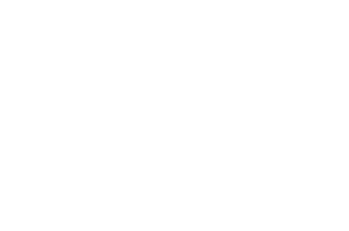

In [45]:
from matplotlib.animation import FuncAnimation

lines = []
circles = []
def _init_lines():
    lines.extend([ax.plot([], [], alpha=0.3)[0] for i in range(n)])

def _init_circles():
    for i in range(n):
        radius = np.abs(pos[i+1][0] - pos[i][0])
        circle = pylab.Circle((-1, -1), radius, alpha=0.3, fill=False)
        circles.append(circle)
        ax.add_artist(circle)

path_x = []
path_y = []

def init_frame():
    ax.clear()
    ax.set(xlim=[0, 1], ylim=[0, 1])
    ax.axis('off')
    _init_lines()
    _init_circles()
    global path
    path = ax.plot([], [])[0]

def _render_lines(k):
    for i in range(n):
        p, q = pos[i][k], pos[i+1][k]
        lines[i].set_data([p.real, q.real], [p.imag, q.imag])

def _render_circles(k):
    for i in range(n):
        p = pos[i][k]
        circles[i].center = (p.real, p.imag)

def render_frame(k):
    _render_lines(k)
    _render_circles(k)
    p = pos[n][k]
    path_x.append(p.real)
    path_y.append(p.imag)
    path.set_data(path_x, path_y)

fig, ax = pylab.subplots()
animation = FuncAnimation(fig,
                          render_frame,
                          frames=range(frames),
                          interval=100,
                          repeat_delay=1000,
                          init_func=init_frame,
                          repeat=True)


from IPython.display import HTML
HTML(animation.to_jshtml())